In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
from torch import nn, autograd, optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.utils import data
from torchvision import transforms, utils
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.nn import functional as F
from torch.autograd import Function
from torch.utils.cpp_extension import load
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import math
import random
import functools
import operator

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
#Most of this code was taken from following github repositories
#I do not claim their property and am hereby mentioning the code base
#They have also been cited in the paper
#https://github.com/rosinality/stylegan2-pytorch
#https://github.com/NVlabs/stylegan3
#https://github.com/NVlabs/stylegan2-ada-pytorch

#set to defaults in the implementation of @rosinality/stylegan2

#total training iterations
n_iter = 800001 #default: 800000
#batch sizes for gpu
n_batch = 16
#number of the samples generated during training
n_sample = 64
#image sizes for the model
size = 128#64 #scale up to 128 later, default: 256
#weight of the r1 regularization
r1 = float(10)
#weight of the path length regularization
path_regularize = float(2)
#batch size reducing factor for the path length regularization (reduce memory consumption)
path_batch_shrink = 2
#interval of the applying r1 regularization
d_reg_every = 16
#interval of the applying path length regularization
g_reg_every = 4
#probability of latent code mixing
mixing = float(0.9)
#path to the checkpoints to resume training
chkpt = 'drive/My_Drive/training/saveStyleGAN/checkpoint/707000.pt' #default:None
#learning rate
lr = 0.002
#channel multiplication factor for the model
channel_multiplier = 1 #config-f =2 else = 1?
#use weights and biases logging
wandb_store = False
#apply non leaking augmentation
augment = False#True
#probability of applying augmentation. 0=use adaptive augmentation
augment_p = float(0)
#target augmentation probability for adaptive augmentation
ada_target = float(0.6)
#target duration to reach augmentation probability for adaptive augmentation
ada_length = 500*1000
#probability update interval of the adaptive augmentation
ada_every = 256
n_gpu = 1
latent = 512
n_mlp = 8
start_iter = 0
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [3]:
#from https://github.com/NVlabs/stylegan2-ada-pytorch
import contextlib
import warnings
from collections import abc


enabled = True
weight_gradients_disabled = False

@contextlib.contextmanager

def no_weight_gradients():
    global weight_gradients_disabled

    old = weight_gradients_disabled
    weight_gradients_disabled = True
    yield
    weight_gradients_disabled = old


def conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1):
    if could_use_op(input):
        return conv2d_gradfix(
            transpose=False,
            weight_shape=weight.shape,
            stride=stride,
            padding=padding,
            output_padding=0,
            dilation=dilation,
            groups=groups,
        ).apply(input, weight, bias)

    return F.conv2d(
        input=input,
        weight=weight,
        bias=bias,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
    )


def conv_transpose2d(
    input,
    weight,
    bias=None,
    stride=1,
    padding=0,
    output_padding=0,
    groups=1,
    dilation=1,
):

    if could_use_op(input):
        return conv2d_gradfix(
            transpose=True,
            weight_shape=weight.shape,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            groups=groups,
            dilation=dilation,
        ).apply(input, weight, bias)

    return F.conv_transpose2d(
        input=input,
        weight=weight,
        bias=bias,
        stride=stride,
        padding=padding,
        output_padding=output_padding,
        dilation=dilation,
        groups=groups,
    )


def could_use_op(input):
    if (not enabled) or (not torch.backends.cudnn.enabled):
        return False

    if input.device.type != "cuda":
        return False

    if any(torch.__version__.startswith(x) for x in ["1.7.", "1.8."]):
        return True

    warnings.warn(
        f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
    )

    return False

def ensure_tuple(xs, ndim):
    xs = tuple(xs) if isinstance(xs, (tuple, list)) else (xs,) * ndim

    return xs

def conv2d_gradfix(
    transpose, weight_shape, stride, padding, output_padding, dilation, groups
):
    ndim = 2
    weight_shape = tuple(weight_shape)
    stride = ensure_tuple(stride, ndim)
    padding = ensure_tuple(padding, ndim)
    output_padding = ensure_tuple(output_padding, ndim)
    dilation = ensure_tuple(dilation, ndim)

    key = (transpose, weight_shape, stride, padding, output_padding, dilation, groups)
    if key in conv2d_gradfix_cache:
        return conv2d_gradfix_cache[key]

    common_kwargs = dict(
        stride=stride, padding=padding, dilation=dilation, groups=groups
    )

    def calc_output_padding(input_shape, output_shape):
        if transpose:
            return [0, 0]

        return [
            input_shape[i + 2]
            - (output_shape[i + 2] - 1) * stride[i]
            - (1 - 2 * padding[i])
            - dilation[i] * (weight_shape[i + 2] - 1)
            for i in range(ndim)
        ]

    class Conv2d(autograd.Function):
        @staticmethod
        def forward(ctx, input, weight, bias):
            if not transpose:
                out = F.conv2d(input=input, weight=weight, bias=bias, **common_kwargs)

            else:
                out = F.conv_transpose2d(
                    input=input,
                    weight=weight,
                    bias=bias,
                    output_padding=output_padding,
                    **common_kwargs,
                )

            ctx.save_for_backward(input, weight)

            return out

        @staticmethod
        def backward(ctx, grad_output):
            input, weight = ctx.saved_tensors
            grad_input, grad_weight, grad_bias = None, None, None

            if ctx.needs_input_grad[0]:
                p = calc_output_padding(
                    input_shape=input.shape, output_shape=grad_output.shape
                )
                grad_input = conv2d_gradfix(
                    transpose=(not transpose),
                    weight_shape=weight_shape,
                    output_padding=p,
                    **common_kwargs,
                ).apply(grad_output, weight, None)

            if ctx.needs_input_grad[1] and not weight_gradients_disabled:
                grad_weight = Conv2dGradWeight.apply(grad_output, input)

            if ctx.needs_input_grad[2]:
                grad_bias = grad_output.sum((0, 2, 3))

            return grad_input, grad_weight, grad_bias

    class Conv2dGradWeight(autograd.Function):
        @staticmethod
        def forward(ctx, grad_output, input):
            op = torch._C._jit_get_operation(
                "aten::cudnn_convolution_backward_weight"
                if not transpose
                else "aten::cudnn_convolution_transpose_backward_weight"
            )
            op = op[0]
            flags = [
                torch.backends.cudnn.benchmark,
                torch.backends.cudnn.deterministic,
                torch.backends.cudnn.allow_tf32,
            ]
            grad_weight = op(
                weight_shape,
                grad_output,
                input,
                padding,
                stride,
                dilation,
                groups,
                *flags,
            )
            ctx.save_for_backward(grad_output, input)

            return grad_weight

        @staticmethod
        def backward(ctx, grad_grad_weight):
            grad_output, input = ctx.saved_tensors
            grad_grad_output, grad_grad_input = None, None

            if ctx.needs_input_grad[0]:
                grad_grad_output = Conv2d.apply(input, grad_grad_weight, None)

            if ctx.needs_input_grad[1]:
                p = calc_output_padding(
                    input_shape=input.shape, output_shape=grad_output.shape
                )
                grad_grad_input = conv2d_gradfix(
                    transpose=(not transpose),
                    weight_shape=weight_shape,
                    output_padding=p,
                    **common_kwargs,
                ).apply(grad_output, grad_grad_weight, None)

            return grad_grad_output, grad_grad_input

    conv2d_gradfix_cache[key] = Conv2d

    return Conv2d

#Custom PyTorch ops for resampling of 2d images
def upfirdn2d(input, kernel, up=1, down=1, padding=(0, 0)):
    pad=padding
    if not isinstance(up, abc.Iterable):
        up = (up, up)

    if not isinstance(down, abc.Iterable):
        down = (down, down)

    if len(pad) == 2:
        pad = (pad[0], pad[1], pad[0], pad[1])

    out = upfirdn2d_native(input, kernel, *up, *down, *pad)

    return out
def upfirdn2d_native(
    input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1
):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(
        out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)]
    )
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape(
        [-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1]
    )
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h + down_y) // down_y
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w + down_x) // down_x

    return out.view(-1, channel, out_h, out_w)


class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, bias=True, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        if bias:
            self.bias = nn.Parameter(torch.zeros(channel))

        else:
            self.bias = None

        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)
def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if bias is not None:
        rest_dim = [1] * (input.ndim - bias.ndim - 1)
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=0.2
            )
            * scale
        )

In [4]:
#Classes and functions needed for generator and discriminator
#Needed for creating multilayer perceptron
class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
            f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
        )


class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out
    
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k

class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, padding=self.pad)
        return out

class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, padding=self.pad)

        return out

class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer("kernel", kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, padding=self.pad)

        return out

class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
        )
    
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out
class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        fused=True,
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2
            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate
        self.fused = fused

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, "
            f"upsample={self.upsample}, downsample={self.downsample})"
        )
    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        if not self.fused:
            weight = self.scale * self.weight.squeeze(0)
            style = self.modulation(style)

            if self.demodulate:
                w = weight.unsqueeze(0) * style.view(batch, 1, in_channel, 1, 1)
                dcoefs = (w.square().sum((2, 3, 4)) + 1e-8).rsqrt()

            input = input * style.reshape(batch, in_channel, 1, 1)

            if self.upsample:
                weight = weight.transpose(0, 1)
                out = conv_transpose2d(
                    input, weight, padding=0, stride=2
                )
                out = self.blur(out)

            elif self.downsample:
                input = self.blur(input)
                out = conv2d(input, weight, padding=0, stride=2)

            else:
                out = conv2d(input, weight, padding=self.padding)

            if self.demodulate:
                out = out * dcoefs.view(batch, -1, 1, 1)

            return out
        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = conv_transpose2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)
        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = conv2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = conv2d(
                input, weight, padding=self.padding, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out

class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise



class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out

class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out

#Needed for Discriminator:
class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        bias=True,
        activate=True,
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        layers.append(
            EqualConv2d(
                in_channel,
                out_channel,
                kernel_size,
                padding=self.padding,
                stride=stride,
                bias=bias and not activate,
            )
        )

        if activate:
            layers.append(FusedLeakyReLU(out_channel, bias=bias))

        super().__init__(*layers)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        self.conv1 = ConvLayer(in_channel, in_channel, 3)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)

        self.skip = ConvLayer(
            in_channel, out_channel, 1, downsample=True, activate=False, bias=False
        )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        skip = self.skip(input)
        out = (out + skip) / math.sqrt(2)

        return out


In [5]:
# Generator Code
#Notes:
#n_mlp = number of multilayer perceptron = a fully connected class of feedforward artificial neural network
class Generator(nn.Module):
    def __init__(self, size,style_dim,n_mlp,channel_multiplier=2, blur_kernel = [1,3,3,1], lr_mlp=0.01):
        super().__init__()
        self.size = size
        self.style_dim = style_dim
        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation="fused_lrelu"
                )
            )
        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }
        self.style = nn.Sequential(*layers)
        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]
        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f"noise_{layer_idx}", torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises
    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(self,styles,return_latents=False,inject_index=None,truncation=1,
        truncation_latent=None,input_is_latent=False,noise=None,randomize_noise=True,):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f"noise_{i}") for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t
        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)

            i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, None


In [6]:
class Discriminator(nn.Module):
    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]

        log_size = int(math.log(size, 2))

        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]

            convs.append(ResBlock(in_channel, out_channel, blur_kernel))

            in_channel = out_channel

        self.convs = nn.Sequential(*convs)

        self.stddev_group = 4
        self.stddev_feat = 1
        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4, channels[4], activation="fused_lrelu"),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(
            group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
        )
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.view(batch, -1)
        out = self.final_linear(out)

        return out

In [7]:
#helper function for training module
try:
    import wandb
except ImportError:
    wandb = None
import torch.distributed as dist
#from https://github.com/rosinality/stylegan2-pytorch/blob/3dee637b8937bf3830991c066ed8d9cc58afd661/distributed.py
def get_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    return dist.get_rank()
def reduce_sum(tensor):
    if not dist.is_available():
        return tensor

    if not dist.is_initialized():
        return tensor

    tensor = tensor.clone()
    dist.all_reduce(tensor, op=dist.ReduceOp.SUM)

    return tensor
def get_world_size():
    if not dist.is_available():
        return 1

    if not dist.is_initialized():
        return 1

    return dist.get_world_size()
def reduce_loss_dict(loss_dict):
    world_size = get_world_size()

    if world_size < 2:
        return loss_dict

    with torch.no_grad():
        keys = []
        losses = []

        for k in sorted(loss_dict.keys()):
            keys.append(k)
            losses.append(loss_dict[k])

        losses = torch.stack(losses, 0)
        dist.reduce(losses, dst=0)

        if dist.get_rank() == 0:
            losses /= world_size

        reduced_losses = {k: v for k, v in zip(keys, losses)}

    return reduced_losses
##from non_leaking.py
class AdaptiveAugment:
    def __init__(self, ada_aug_target, ada_aug_len, update_every, device):
        self.ada_aug_target = ada_aug_target
        self.ada_aug_len = ada_aug_len
        self.update_every = update_every

        self.ada_update = 0
        self.ada_aug_buf = torch.tensor([0.0, 0.0], device=device)
        self.r_t_stat = 0
        self.ada_aug_p = 0

    @torch.no_grad()
    def tune(self, real_pred):
        self.ada_aug_buf += torch.tensor(
            (torch.sign(real_pred).sum().item(), real_pred.shape[0]),
            device=real_pred.device,
        )
        self.ada_update += 1

        if self.ada_update % self.update_every == 0:
            self.ada_aug_buf = reduce_sum(self.ada_aug_buf)
            pred_signs, n_pred = self.ada_aug_buf.tolist()

            self.r_t_stat = pred_signs / n_pred

            if self.r_t_stat > self.ada_aug_target:
                sign = 1

            else:
                sign = -1

            self.ada_aug_p += sign * n_pred / self.ada_aug_len
            self.ada_aug_p = min(1, max(0, self.ada_aug_p))
            self.ada_aug_buf.mul_(0)
            self.ada_update = 0

        return self.ada_aug_p


SYM6 = (
    0.015404109327027373,
    0.0034907120842174702,
    -0.11799011114819057,
    -0.048311742585633,
    0.4910559419267466,
    0.787641141030194,
    0.3379294217276218,
    -0.07263752278646252,
    -0.021060292512300564,
    0.04472490177066578,
    0.0017677118642428036,
    -0.007800708325034148,
)


def translate_mat(t_x, t_y, device="cpu"):
    batch = t_x.shape[0]

    mat = torch.eye(3, device=device).unsqueeze(0).repeat(batch, 1, 1)
    translate = torch.stack((t_x, t_y), 1)
    mat[:, :2, 2] = translate

    return mat


def rotate_mat(theta, device="cpu"):
    batch = theta.shape[0]

    mat = torch.eye(3, device=device).unsqueeze(0).repeat(batch, 1, 1)
    sin_t = torch.sin(theta)
    cos_t = torch.cos(theta)
    rot = torch.stack((cos_t, -sin_t, sin_t, cos_t), 1).view(batch, 2, 2)
    mat[:, :2, :2] = rot

    return mat


def scale_mat(s_x, s_y, device="cpu"):
    batch = s_x.shape[0]

    mat = torch.eye(3, device=device).unsqueeze(0).repeat(batch, 1, 1)
    mat[:, 0, 0] = s_x
    mat[:, 1, 1] = s_y

    return mat


def translate3d_mat(t_x, t_y, t_z):
    batch = t_x.shape[0]

    mat = torch.eye(4).unsqueeze(0).repeat(batch, 1, 1)
    translate = torch.stack((t_x, t_y, t_z), 1)
    mat[:, :3, 3] = translate

    return mat


def rotate3d_mat(axis, theta):
    batch = theta.shape[0]

    u_x, u_y, u_z = axis

    eye = torch.eye(3).unsqueeze(0)
    cross = torch.tensor([(0, -u_z, u_y), (u_z, 0, -u_x), (-u_y, u_x, 0)]).unsqueeze(0)
    outer = torch.tensor(axis)
    outer = (outer.unsqueeze(1) * outer).unsqueeze(0)

    sin_t = torch.sin(theta).view(-1, 1, 1)
    cos_t = torch.cos(theta).view(-1, 1, 1)

    rot = cos_t * eye + sin_t * cross + (1 - cos_t) * outer

    eye_4 = torch.eye(4).unsqueeze(0).repeat(batch, 1, 1)
    eye_4[:, :3, :3] = rot

    return eye_4


def scale3d_mat(s_x, s_y, s_z):
    batch = s_x.shape[0]

    mat = torch.eye(4).unsqueeze(0).repeat(batch, 1, 1)
    mat[:, 0, 0] = s_x
    mat[:, 1, 1] = s_y
    mat[:, 2, 2] = s_z

    return mat


def luma_flip_mat(axis, i):
    batch = i.shape[0]

    eye = torch.eye(4).unsqueeze(0).repeat(batch, 1, 1)
    axis = torch.tensor(axis + (0,))
    flip = 2 * torch.ger(axis, axis) * i.view(-1, 1, 1)

    return eye - flip


def saturation_mat(axis, i):
    batch = i.shape[0]

    eye = torch.eye(4).unsqueeze(0).repeat(batch, 1, 1)
    axis = torch.tensor(axis + (0,))
    axis = torch.ger(axis, axis)
    saturate = axis + (eye - axis) * i.view(-1, 1, 1)

    return saturate


def lognormal_sample(size, mean=0, std=1, device="cpu"):
    return torch.empty(size, device=device).log_normal_(mean=mean, std=std)


def category_sample(size, categories, device="cpu"):
    category = torch.tensor(categories, device=device)
    sample = torch.randint(high=len(categories), size=(size,), device=device)

    return category[sample]


def uniform_sample(size, low, high, device="cpu"):
    return torch.empty(size, device=device).uniform_(low, high)


def normal_sample(size, mean=0, std=1, device="cpu"):
    return torch.empty(size, device=device).normal_(mean, std)


def bernoulli_sample(size, p, device="cpu"):
    return torch.empty(size, device=device).bernoulli_(p)


def random_mat_apply(p, transform, prev, eye, device="cpu"):
    size = transform.shape[0]
    select = bernoulli_sample(size, p, device=device).view(size, 1, 1)
    select_transform = select * transform + (1 - select) * eye

    return select_transform @ prev


def sample_affine(p, size, height, width, device="cpu"):
    G = torch.eye(3, device=device).unsqueeze(0).repeat(size, 1, 1)
    eye = G

    # flip
    param = category_sample(size, (0, 1))
    Gc = scale_mat(1 - 2.0 * param, torch.ones(size), device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('flip', G, scale_mat(1 - 2.0 * param, torch.ones(size)), sep='\n')

    # 90 rotate
    param = category_sample(size, (0, 3))
    Gc = rotate_mat(-math.pi / 2 * param, device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('90 rotate', G, rotate_mat(-math.pi / 2 * param), sep='\n')

    # integer translate
    param = uniform_sample((2, size), -0.125, 0.125)
    param_height = torch.round(param[0] * height)
    param_width = torch.round(param[1] * width)
    Gc = translate_mat(param_width, param_height, device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('integer translate', G, translate_mat(param_width, param_height), sep='\n')

    # isotropic scale
    param = lognormal_sample(size, std=0.2 * math.log(2))
    Gc = scale_mat(param, param, device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('isotropic scale', G, scale_mat(param, param), sep='\n')

    p_rot = 1 - math.sqrt(1 - p)

    # pre-rotate
    param = uniform_sample(size, -math.pi, math.pi)
    Gc = rotate_mat(-param, device=device)
    G = random_mat_apply(p_rot, Gc, G, eye, device=device)
    # print('pre-rotate', G, rotate_mat(-param), sep='\n')

    # anisotropic scale
    param = lognormal_sample(size, std=0.2 * math.log(2))
    Gc = scale_mat(param, 1 / param, device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('anisotropic scale', G, scale_mat(param, 1 / param), sep='\n')

    # post-rotate
    param = uniform_sample(size, -math.pi, math.pi)
    Gc = rotate_mat(-param, device=device)
    G = random_mat_apply(p_rot, Gc, G, eye, device=device)
    # print('post-rotate', G, rotate_mat(-param), sep='\n')

    # fractional translate
    param = normal_sample((2, size), std=0.125)
    Gc = translate_mat(param[1] * width, param[0] * height, device=device)
    G = random_mat_apply(p, Gc, G, eye, device=device)
    # print('fractional translate', G, translate_mat(param, param), sep='\n')

    return G


def sample_color(p, size):
    C = torch.eye(4).unsqueeze(0).repeat(size, 1, 1)
    eye = C
    axis_val = 1 / math.sqrt(3)
    axis = (axis_val, axis_val, axis_val)

    # brightness
    param = normal_sample(size, std=0.2)
    Cc = translate3d_mat(param, param, param)
    C = random_mat_apply(p, Cc, C, eye)

    # contrast
    param = lognormal_sample(size, std=0.5 * math.log(2))
    Cc = scale3d_mat(param, param, param)
    C = random_mat_apply(p, Cc, C, eye)

    # luma flip
    param = category_sample(size, (0, 1))
    Cc = luma_flip_mat(axis, param)
    C = random_mat_apply(p, Cc, C, eye)

    # hue rotation
    param = uniform_sample(size, -math.pi, math.pi)
    Cc = rotate3d_mat(axis, param)
    C = random_mat_apply(p, Cc, C, eye)

    # saturation
    param = lognormal_sample(size, std=1 * math.log(2))
    Cc = saturation_mat(axis, param)
    C = random_mat_apply(p, Cc, C, eye)

    return C


def make_grid(shape, x0, x1, y0, y1, device):
    n, c, h, w = shape
    grid = torch.empty(n, h, w, 3, device=device)
    grid[:, :, :, 0] = torch.linspace(x0, x1, w, device=device)
    grid[:, :, :, 1] = torch.linspace(y0, y1, h, device=device).unsqueeze(-1)
    grid[:, :, :, 2] = 1

    return grid


def affine_grid(grid, mat):
    n, h, w, _ = grid.shape
    return (grid.view(n, h * w, 3) @ mat.transpose(1, 2)).view(n, h, w, 2)


def get_padding(G, height, width, kernel_size):
    device = G.device

    cx = (width - 1) / 2
    cy = (height - 1) / 2
    cp = torch.tensor(
        [(-cx, -cy, 1), (cx, -cy, 1), (cx, cy, 1), (-cx, cy, 1)], device=device
    )
    cp = G @ cp.T

    pad_k = kernel_size // 4

    pad = cp[:, :2, :].permute(1, 0, 2).flatten(1)
    pad = torch.cat((-pad, pad)).max(1).values
    pad = pad + torch.tensor([pad_k * 2 - cx, pad_k * 2 - cy] * 2, device=device)
    pad = pad.max(torch.tensor([0, 0] * 2, device=device))
    pad = pad.min(torch.tensor([width - 1, height - 1] * 2, device=device))

    pad_x1, pad_y1, pad_x2, pad_y2 = pad.ceil().to(torch.int32)

    return pad_x1, pad_x2, pad_y1, pad_y2


def try_sample_affine_and_pad(img, p, kernel_size, G=None):
    batch, _, height, width = img.shape

    G_try = G

    if G is None:
        G_try = torch.inverse(sample_affine(p, batch, height, width))

    pad_x1, pad_x2, pad_y1, pad_y2 = get_padding(G_try, height, width, kernel_size)

    img_pad = F.pad(img, (pad_x1, pad_x2, pad_y1, pad_y2), mode="reflect")

    return img_pad, G_try, (pad_x1, pad_x2, pad_y1, pad_y2)

"""Custom replacement for `torch.nn.functional.grid_sample` that
supports arbitrarily high order gradients between the input and output.
Only works on 2D images and assumes
`mode='bilinear'`, `padding_mode='zeros'`, `align_corners=False`."""
#https://github.com/NVlabs/stylegan3/blob/main/torch_utils/ops/grid_sample_gradfix.py
class GridSampleForward(autograd.Function):
    @staticmethod
    def forward(ctx, input, grid):
        assert input.ndim == 4
        assert grid.ndim == 4
        out = F.grid_sample(
            input, grid, mode="bilinear", padding_mode="zeros", align_corners=False
        )
        ctx.save_for_backward(input, grid)

        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, grid = ctx.saved_tensors
        grad_input, grad_grid = GridSampleBackward.apply(grad_output, input, grid)

        return grad_input, grad_grid


class GridSampleBackward(autograd.Function):
    @staticmethod
    def forward(ctx, grad_output, input, grid):
        op = torch._C._jit_get_operation("aten::grid_sampler_2d_backward")
        op = op[0]
        #Problem is that op is taken as a tuple object
        output_mask = (ctx.needs_input_grad[1], ctx.needs_input_grad[2])
        grad_input, grad_grid = op(grad_output, input, grid, 0, 0, False, output_mask)
        #grad_input, grad_grid = op(grad_output, input, grid, 0, 0, False)
        ctx.save_for_backward(grid)

        return grad_input, grad_grid

    @staticmethod
    def backward(ctx, grad_grad_input, grad_grad_grid):
        (grid,) = ctx.saved_tensors
        grad_grad_output = None

        if ctx.needs_input_grad[0]:
            grad_grad_output = GridSampleForward.apply(grad_grad_input, grid)
        assert not ctx.needs_input_grad[2]
        return grad_grad_output, None, None


#grid_sample = GridSampleForward.apply
_should_use_custom_op = True
def grid_sample(input, grid):
    if _should_use_custom_op:
        return GridSampleForward.apply(input, grid)
    return torch.nn.functional.grid_sample(input=input, grid=grid, mode='bilinear', padding_mode='zeros', align_corners=False)

def scale_mat_single(s_x, s_y):
    return torch.tensor(((s_x, 0, 0), (0, s_y, 0), (0, 0, 1)), dtype=torch.float32)


def translate_mat_single(t_x, t_y):
    return torch.tensor(((1, 0, t_x), (0, 1, t_y), (0, 0, 1)), dtype=torch.float32)


def random_apply_affine(img, p, G=None, antialiasing_kernel=SYM6):
    kernel = antialiasing_kernel
    len_k = len(kernel)

    kernel = torch.as_tensor(kernel).to(img)
    # kernel = torch.ger(kernel, kernel).to(img)
    kernel_flip = torch.flip(kernel, (0,))


    img_pad, G, (pad_x1, pad_x2, pad_y1, pad_y2) = try_sample_affine_and_pad(
        img, p, len_k, G
    )

    G_inv = (
        translate_mat_single((pad_x1 - pad_x2).item() / 2, (pad_y1 - pad_y2).item() / 2)
        @ G
    )
    up_pad = (
        (len_k + 2 - 1) // 2,
        (len_k - 2) // 2,
        (len_k + 2 - 1) // 2,
        (len_k - 2) // 2,
    )
    img_2x = upfirdn2d(img_pad, kernel.unsqueeze(0), up=(2, 1), padding=(*up_pad[:2], 0, 0))
    img_2x = upfirdn2d(img_2x, kernel.unsqueeze(1), up=(1, 2), padding=(0, 0, *up_pad[2:]))
    G_inv = scale_mat_single(2, 2) @ G_inv @ scale_mat_single(1 / 2, 1 / 2)
    G_inv = translate_mat_single(-0.5, -0.5) @ G_inv @ translate_mat_single(0.5, 0.5)
    batch_size, channel, height, width = img.shape
    pad_k = len_k // 4
    shape = (batch_size, channel, (height + pad_k * 2) * 2, (width + pad_k * 2) * 2)
    G_inv = (
        scale_mat_single(2 / img_2x.shape[3], 2 / img_2x.shape[2])
        @ G_inv
        @ scale_mat_single(1 / (2 / shape[3]), 1 / (2 / shape[2]))
    )
    grid = F.affine_grid(G_inv[:, :2, :].to(img_2x), shape, align_corners=False)
    img_affine = grid_sample(img_2x, grid)
    d_p = -pad_k * 2
    down_pad = (
        d_p + (len_k - 2 + 1) // 2,
        d_p + (len_k - 2) // 2,
        d_p + (len_k - 2 + 1) // 2,
        d_p + (len_k - 2) // 2,
    )
    img_down = upfirdn2d(
        img_affine, kernel_flip.unsqueeze(0), down=(2, 1), padding=(*down_pad[:2], 0, 0)
    )
    img_down = upfirdn2d(
        img_down, kernel_flip.unsqueeze(1), down=(1, 2), padding=(0, 0, *down_pad[2:])
    )

    return img_down, G


def apply_color(img, mat):
    batch = img.shape[0]
    img = img.permute(0, 2, 3, 1)
    mat_mul = mat[:, :3, :3].transpose(1, 2).view(batch, 1, 3, 3)
    mat_add = mat[:, :3, 3].view(batch, 1, 1, 3)
    img = img @ mat_mul + mat_add
    img = img.permute(0, 3, 1, 2)

    return img


def random_apply_color(img, p, C=None):
    if C is None:
        C = sample_color(p, img.shape[0])

    img = apply_color(img, C.to(img))

    return img, C



def augment(img, p, transform_matrix=(None, None)):
    img, G = random_apply_affine(img, p, transform_matrix[0])
    img, C = random_apply_color(img, p, transform_matrix[1])

    return img, (G, C)

In [8]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


In [9]:
#adapted from https://github.com/rosinality/stylegan2-pytorch/blob/master/train.py
G_losses = []
D_losses = []

def train(loader, generator, discriminator, g_optim, d_optim, g_ema, start_iter):

    loader = sample_data(loader)

    pbar = range(n_iter)

    pbar = tqdm(pbar, initial=start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}


    g_module = generator
    d_module = discriminator
        
    accum = 0.5 ** (32 / (10 * 1000))
    ada_aug_p = augment_p if augment_p > 0 else 0.0
    r_t_stat = 0

    if augment==True and augment_p == 0:
        ada_augment = AdaptiveAugment(ada_target, ada_length, 8, device)

    sample_z = torch.randn(n_sample, latent, device=device)
    """for i,data in enumerate(loader):
        x,t = data
        x,t = x.to(device),t.to(device)
        print("Success")"""

    for idx in pbar:
        i = idx + start_iter

        if i > n_iter:
            print("Done!")

            break

        real_img,do_not_need = next(iter(loader))
        real_img = real_img.to(device)

        requires_grad(generator, False)
        requires_grad(discriminator, True)

        noise = mixing_noise(n_batch, latent, mixing, device)
        fake_img, _ = generator(noise)

        if augment:
            real_img_aug, _ = augment(real_img, ada_aug_p)
            fake_img, _ = augment(fake_img, ada_aug_p)
        else:
            real_img_aug = real_img

        fake_pred = discriminator(fake_img)
        real_pred = discriminator(real_img_aug)
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

        if augment==True and augment_p == 0:
            ada_aug_p = ada_augment.tune(real_pred)
            r_t_stat = ada_augment.r_t_stat

        d_regularize = i % d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True

            if augment:
                real_img_aug, _ = augment(real_img, ada_aug_p)

            else:
                real_img_aug = real_img

            real_pred = discriminator(real_img_aug)
            r1_loss = d_r1_loss(real_pred, real_img)
            
            discriminator.zero_grad()
            (r1 / 2 * r1_loss * d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(discriminator, False)

        noise = mixing_noise(n_batch, latent, mixing, device)
        fake_img, _ = generator(noise)

        if augment:
            fake_img, _ = augment(fake_img, ada_aug_p)

        fake_pred = discriminator(fake_img)
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        g_loss.backward()
        g_optim.step()

        g_regularize = i % g_reg_every == 0
        
        if g_regularize:
            path_batch_size = max(1, n_batch // path_batch_shrink)
            noise = mixing_noise(path_batch_size, latent, mixing, device)
            fake_img, latents = generator(noise, return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            weighted_path_loss = path_regularize * g_reg_every * path_loss

            if path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)
        
        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()
        G_losses.append(d_loss_val)
        D_losses.append(g_loss_val)

        if get_rank() == 0:
            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}; "
                    f"augment: {ada_aug_p:.4f}"
                )
            )

            if wandb is not None and wandb_store==True:
                wandb.log(
                    {
                        "Generator": g_loss_val,
                        "Discriminator": d_loss_val,
                        "Augment": ada_aug_p,
                        "Rt": r_t_stat,
                        "R1": r1_val,
                        "Path Length Regularization": path_loss_val,
                        "Mean Path Length": mean_path_length,
                        "Real Score": real_score_val,
                        "Fake Score": fake_score_val,
                        "Path Length": path_length_val,
                    }
                )
            if i % 1000 == 0:
                with torch.no_grad():
                    g_ema.eval()
                    sample, _ = g_ema([sample_z])
                    utils.save_image(
                        sample,
                        f"drive/My_Drive/training/saveStyleGAN/sample/{str(i).zfill(6)}.png",
                        nrow=int(n_sample ** 0.5),
                        normalize=True,
                        range=(-1, 1),
                    )
                print('[%d/%d]: Loss_D: %.4f Loss_G: %.4f Real score: %.4f Fake score: %.4f'
                     %(i,n_iter,g_loss_val, d_loss_val,real_score_val,fake_score_val))

            if i % 1000 == 0:
                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "ada_aug_p": ada_aug_p,
                    },
                    f"drive/My_Drive/training/saveStyleGAN/checkpoint/{str(i).zfill(6)}.pt",
                )

                
                                  

In [10]:

def interpolate(g_ema):
    # Set random seed for reproducibility
    manualSeed = 1009#999
    #manualSeed = random.randint(1, 10000) # use if you want new results
    print("Random Seed: ", manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    col_size = 8
    log_size = int(math.log(size, 2))
    num_layers = (log_size - 2) * 2 + 1
    sample_z = torch.randn(n_sample, latent, device=device)
    z0 = (sample_z[col_size*4:(col_size*5)]).repeat(col_size,1) #latents low
    z1 = (sample_z[(64-(2*col_size)):64-col_size]).repeat(col_size,1) # latents high
    #z0 = (sample_z[0:col_size]).repeat(col_size,1) #latents low
    #z1 = (sample_z[(64-col_size):]).repeat(col_size,1) # latents high
    print(z0.size(),z1.size())
    t = torch.linspace(0,1,8).unsqueeze(1).repeat(1,col_size).flatten(0).unsqueeze(1).repeat(1,512).to(device)
    lerp_z = (1-t)*z0 + t*z1
    with torch.no_grad():
        g_ema.eval()
        lerp_g, _ = g_ema([lerp_z])
        utils.save_image(
        lerp_g,
        f"drive/My_Drive/training/saveStyleGAN/sample/interpolated.png",
        nrow=int(n_sample ** 0.5),
        normalize=True,
        range=(-1, 1),
        )
        sample, _ = g_ema([sample_z])
        utils.save_image(
        sample,
        f"drive/My_Drive/training/saveStyleGAN/sample/sample.png",
        nrow=int(n_sample ** 0.5),
        normalize=True,
        range=(-1, 1),
        )
    plt.rcParams['figure.dpi'] = 128
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    


load model: drive/My_Drive/training/saveStyleGAN/checkpoint/707000.pt
Start iteration: 707000
Random Seed:  1009
torch.Size([64, 512]) torch.Size([64, 512])


/tmp/ipykernel_3638962/2575117942.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.0+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


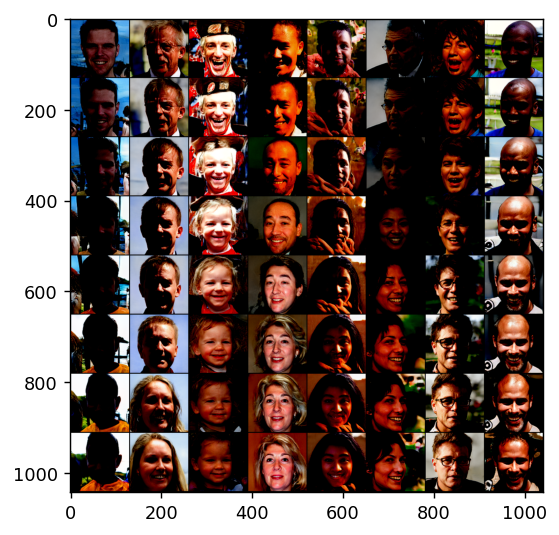

In [11]:

def main():    
    
    generator = Generator(
        size, latent, n_mlp, channel_multiplier=channel_multiplier
    ).to(device)
    discriminator = Discriminator(
        size, channel_multiplier=channel_multiplier
    ).to(device)
    g_ema = Generator(
        size, latent, n_mlp, channel_multiplier=channel_multiplier
    ).to(device)
    g_ema.eval()
    accumulate(g_ema, generator, 0)

    g_reg_ratio = g_reg_every / (g_reg_every + 1)
    d_reg_ratio = d_reg_every / (d_reg_every + 1)

    g_optim = optim.Adam(
        generator.parameters(),
        lr=lr * g_reg_ratio,
        betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
    )
    d_optim = optim.Adam(
        discriminator.parameters(),
        lr=lr * d_reg_ratio,
        betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
    )
    if chkpt is not None:
        print("load model:", chkpt)

        params = torch.load(chkpt)
        #start_iter = 8000
        try:
            chkpt_name = os.path.basename(chkpt)
            start_iter = int(os.path.splitext(chkpt_name)[0])
            print("Start iteration:",start_iter)

        except ValueError:
            pass

        generator.load_state_dict(params["g"])
        discriminator.load_state_dict(params["d"])
        g_ema.load_state_dict(params["g_ema"])

        g_optim.load_state_dict(params["g_optim"])
        d_optim.load_state_dict(params["d_optim"])

    dataroot = 'drive/My_Drive/training/ffhq'
    dataset = torchvision.datasets.ImageFolder(root=dataroot,transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(size),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.CenterCrop(size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ]))
    loader = data.DataLoader(
        dataset,
        batch_size=n_batch,
        sampler=data_sampler(dataset, shuffle=True, distributed=False),
        drop_last=True,
    )

    if wandb is not None and wandb_store==True:
        wandb.init(project="stylegan 2")

    train(loader, generator, discriminator, g_optim, d_optim, g_ema,start_iter)
    interpolate(g_ema)
    
main()

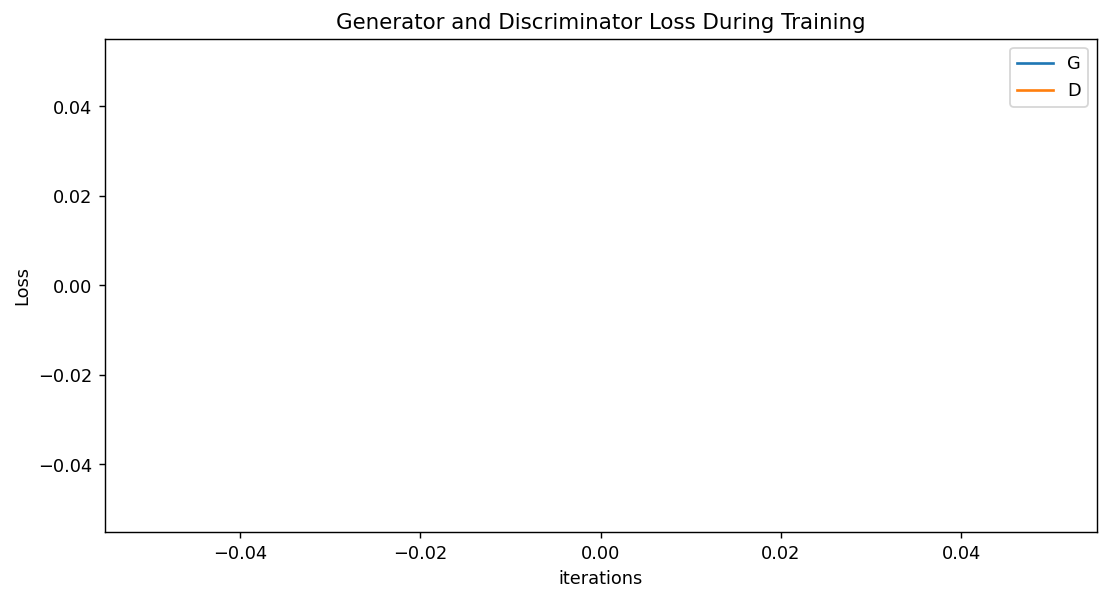

In [12]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
####Code for StyleNAT#####################
#the code base is taken from
#https://github.com/SHI-Labs/StyleNAT
#https://github.com/rosinality/stylegan2-pytorch

#!pip install timm
#!pip install ninja
#!pip install hydra-core
#scipy, sklearn,einops,natten==0.14.4,joblib
#Also have to ensure that CUDA_HOME is defined
#Test with 
#HAS_CUDA = (torch.cuda.is_available() and (CUDA_HOME is not None) or os.getenv("FORCE_CUDA", "0") == "1")
#print(HAS_CUDA)
#print(CUDA_HOME)
#!pip3 install natten -f https://shi-labs.com/natten/wheels/cu117/torch1.13/index.html 

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
from torch import nn, autograd, optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.utils import data
from torchvision import transforms, utils
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.nn import functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.cpp_extension import load
from torch.nn.utils import spectral_norm
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import math
import random
import functools
import operator
import warnings
####Packages just for StyleNAT
import hydra
import builtins
import time
import sys
import natten
#from joblib import Parallel, delayed

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#set to defaults in the implementation of @rosinality/stylegan2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')#"cuda"
torch.cuda.set_device(device)
#number of the samples generated during training
n_sample = 16
#image sizes for the model
size = 128 #scale up to 128 later, default: 256
#weight of the path length regularization
path_regularize = float(2)
#batch size reducing factor for the path length regularization (reduce memory consumption)
path_batch_shrink = 2
#probability of latent code mixing
mixing = float(0.9)
#path to the checkpoints to resume training
chkpt = 'drive/My_Drive/training/saveStyleNAT/checkpoint/720000.pt' #default:None
n_gpu = 1
start_iter = 0  

generator_dict = {
    "n_mlp": 8,
    "block_type":"nat",
    "style_dim":512,
    "lr":0.00004, #?? 0.002
    "channel_multiplier":2, #1
    "mlp_ratio":4,
    "use_checkpoint":False,
    "lr_mlp":0.01,
    "enable_full_resolution":8,
    "min_heads":4,
    "qkv_bias":True,
    "qk_scale":None,
    "proj_drop":0.,
    "attn_drop":0.,
    "kernels":[[3],[7],[7],[7],[7],[7],[7],[7],[7]],
    "dilations":[[1],[1],[1,2],[1,4],[1,8],[1,16],[1,32],[1,64],[1,128]],
    "reg_every":4, #null
    "params":0
}

discriminator_dict = {
    "lr": 0.0002,
    "channel_multiplier": 2, #1
    "blur_kernel": [1, 3, 3, 1],
    "sn": True,
    "ssd": False,
    "reg_every": 16,
    "params": 0
}

training_dict = {
    "iter": 1000001, #1000000
    "batch": 4, #8, 16
    "use_flip": True,
    "ttur": True,
    "r1": 10,
    "bcr": True,
    "bcr_fake_lambda": 10,
    "bcr_real_lambda": 10,
    "beta1": 0.0,
    "beta2": 0.99,
    "start_dim": 512,
    "workers": 8,
    "lr_decay": True,
    "lr_decay_start_steps": 775000,
    "gan_weight": 1
}

#from https://github.com/NVlabs/stylegan2-ada-pytorch
from collections import abc

#Custom PyTorch ops for resampling of 2d images
def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    #pad=padding
    if not isinstance(up, abc.Iterable):
        up = (up, up)

    if not isinstance(down, abc.Iterable):
        down = (down, down)

    if len(pad) == 2:
        pad = (pad[0], pad[1], pad[0], pad[1])

    out = upfirdn2d_native(input, kernel, *up, *down, *pad)

    return out
def upfirdn2d_native(
    input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1
):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(
        out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)]
    )
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape(
        [-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1]
    )
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h + down_y) // down_y
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w + down_x) // down_x

    return out.view(-1, channel, out_h, out_w)


class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, bias=True, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        if bias:
            self.bias = nn.Parameter(torch.zeros(channel))

        else:
            self.bias = None

        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)
def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if True:#bias is not None:
        rest_dim = [1] * (input.ndim - bias.ndim - 1)
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=0.2
            )
            * scale
        )
    
#from https://github.com/SHI-Labs/StyleNAT/blob/main/models/basic_layers.py
'''
Most of the Modules from here come from rosinality's StyleGAN2-pytorch
https://github.com/rosinality/stylegan2-pytorch
Also includes fairseq's sinusodial positional embedding
'''
#Dependencies
#from op import fused_leaky_relu, upfirdn2d can be found in above cell

class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer('kernel', kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out


class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},'
            f' {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})'
        )


class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})'
        )


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k


class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out


class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()

        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)

        return out * math.sqrt(2)


class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(
                pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, '
            f'upsample={self.upsample}, downsample={self.downsample})'
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = F.conv_transpose2d(
                input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.reshape(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out


class SinusoidalPositionalEmbedding(nn.Module):
    """Sinusoidal Positional Embedding 1D or 2D (SPE/SPE2d).
    This module is a modified from:
    https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py # noqa
    Based on the original SPE in single dimension, we implement a 2D sinusoidal
    positional encodding (SPE2d), as introduced in Positional Encoding as
    Spatial Inductive Bias in GANs, CVPR'2021.
    Args:
        embedding_dim (int): The number of dimensions for the positional
            encoding.
        padding_idx (int | list[int]): The index for the padding contents. The
            padding positions will obtain an encoding vector filling in zeros.
        init_size (int, optional): The initial size of the positional buffer.
            Defaults to 1024.
        div_half_dim (bool, optional): If true, the embedding will be divided
            by :math:`d/2`. Otherwise, it will be divided by
            :math:`(d/2 -1)`. Defaults to False.
        center_shift (int | None, optional): Shift the center point to some
            index. Defaults to None.
    """

    def __init__(self,
                 embedding_dim,
                 padding_idx,
                 init_size=1024,
                 div_half_dim=False,
                 center_shift=None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.div_half_dim = div_half_dim
        self.center_shift = center_shift

        self.weights = SinusoidalPositionalEmbedding.get_embedding(
            init_size, embedding_dim, padding_idx, self.div_half_dim)

        self.register_buffer('_float_tensor', torch.FloatTensor(1))

        self.max_positions = int(1e5)

    @staticmethod
    def get_embedding(num_embeddings,
                      embedding_dim,
                      padding_idx=None,
                      div_half_dim=False):
        """Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        assert embedding_dim % 2 == 0, (
            'In this version, we request '
            f'embedding_dim divisible by 2 but got {embedding_dim}')

        # there is a little difference from the original paper.
        half_dim = embedding_dim // 2
        if not div_half_dim:
            emb = np.log(10000) / (half_dim - 1)
        else:
            emb = np.log(1e4) / half_dim
        # compute exp(-log10000 / d * i)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        emb = torch.arange(
            num_embeddings, dtype=torch.float).unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)],
                        dim=1).view(num_embeddings, -1)
        if padding_idx is not None:
            emb[padding_idx, :] = 0

        return emb

    def forward(self, input, **kwargs):
        """Input is expected to be of size [bsz x seqlen].
        Returned tensor is expected to be of size  [bsz x seq_len x emb_dim]
        """
        assert input.dim() == 2 or input.dim(
        ) == 4, 'Input dimension should be 2 (1D) or 4(2D)'

        if input.dim() == 4:
            return self.make_grid2d_like(input, **kwargs)

        b, seq_len = input.shape
        max_pos = self.padding_idx + 1 + seq_len

        if self.weights is None or max_pos > self.weights.size(0):
            # recompute/expand embedding if needed
            self.weights = SinusoidalPositionalEmbedding.get_embedding(
                max_pos, self.embedding_dim, self.padding_idx)
        self.weights = self.weights.to(self._float_tensor)

        positions = self.make_positions(input, self.padding_idx).to(
            self._float_tensor.device)

        return self.weights.index_select(0, positions.view(-1)).view(
            b, seq_len, self.embedding_dim).detach()

    def make_positions(self, input, padding_idx):
        mask = input.ne(padding_idx).int()
        return (torch.cumsum(mask, dim=1).type_as(mask) *
                mask).long() + padding_idx

    def make_grid2d(self, height, width, num_batches=1, center_shift=None):
        h, w = height, width
        # if `center_shift` is not given from the outside, use
        # `self.center_shift`
        if center_shift is None:
            center_shift = self.center_shift

        h_shift = 0
        w_shift = 0
        # center shift to the input grid
        if center_shift is not None:
            # if h/w is even, the left center should be aligned with
            # center shift
            if h % 2 == 0:
                h_left_center = h // 2
                h_shift = center_shift - h_left_center
            else:
                h_center = h // 2 + 1
                h_shift = center_shift - h_center

            if w % 2 == 0:
                w_left_center = w // 2
                w_shift = center_shift - w_left_center
            else:
                w_center = w // 2 + 1
                w_shift = center_shift - w_center

        # Note that the index is started from 1 since zero will be padding idx.
        # axis -- (b, h or w)
        x_axis = torch.arange(1, w + 1).unsqueeze(0).repeat(num_batches,
                                                            1) + w_shift
        y_axis = torch.arange(1, h + 1).unsqueeze(0).repeat(num_batches,
                                                            1) + h_shift

        # emb -- (b, emb_dim, h or w)
        x_emb = self(x_axis).transpose(1, 2)
        y_emb = self(y_axis).transpose(1, 2)

        # make grid for x/y axis
        # Note that repeat will copy data. If use learned emb, expand may be
        # better.
        x_grid = x_emb.unsqueeze(2).repeat(1, 1, h, 1)
        y_grid = y_emb.unsqueeze(3).repeat(1, 1, 1, w)

        # cat grid -- (b, 2 x emb_dim, h, w)
        grid = torch.cat([x_grid, y_grid], dim=1)
        return grid.detach()

    def make_grid2d_like(self, x, center_shift=None):
        """Input tensor with shape of (b, ..., h, w) Return tensor with shape
        of (b, 2 x emb_dim, h, w)
        Note that the positional embedding highly depends on the the function,
        ``make_positions``.
        """
        h, w = x.shape[-2:]
        grid = self.make_grid2d(h, w, x.size(0), center_shift)

        return grid.to(x)
#from https://github.com/SHI-Labs/StyleNAT/blob/main/models/stylenat.py
"""
StyleNAT-specific PyTorch Modules
Authors: Steven Walton & Ali Hassani
Provided with StyleNAT
Contact: walton.stevenj@gmail.com
"""

from torch.nn.init import trunc_normal_
from natten.functional import natten2dqkrpb, natten2dav

class HydraNeighborhoodAttention(nn.Module):
    def __init__(self,
                 dim,
                 kernel_sizes, # Array for kernel sizes
                 num_heads,
                 qkv_bias=True,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.,
                 dilations=[1], # Array of dilations
                 ):
        super().__init__()
        if len(kernel_sizes) == 1 and len(dilations) != 1:
            kernel_sizes = [kernel_sizes[0] for _ in range(len(dilations))]
        elif len(dilations) == 1 and len(kernel_sizes) != 1:
            dilations = [dilations[0] for _ in range(len(kernel_sizes))]
        assert(len(kernel_sizes) == len(dilations)),f"Number of kernels ({(kernel_sizes)}) must be the same as number of dilations ({(dilations)})"
        self.num_splits = len(kernel_sizes)
        self.num_heads = num_heads
        self.kernel_sizes = kernel_sizes
        self.dilations = dilations

        self.head_dim = dim // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        asserts = []
        for i in range(len(kernel_sizes)):
            asserts.append(kernel_sizes[i] > 1 and kernel_sizes[i] % 2 == 1)
            if asserts[i] == False:
                warnings.warn(f"Kernel_size {kernel_sizes[i]} needs to be >1 and odd")
        assert(all(asserts)),f"Kernel sizes must be >1 AND odd. Got {kernel_sizes}"

        self.window_size = []
        for i in range(len(dilations)):
            self.window_size.append(self.kernel_sizes[i] * self.dilations[i])

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        # Needs to be fixed if we want uneven head splits. // is floored
        # division
        if num_heads % len(kernel_sizes) == 0:
            self.rpb = nn.ParameterList([nn.Parameter(torch.zeros(num_heads//self.num_splits, (2*k-1), (2*k-1))) for k in kernel_sizes])
            self.clean_partition = True
        else:
            diff = num_heads - self.num_splits * (num_heads // self.num_splits)
            rpb = [nn.Parameter(torch.zeros(num_heads//self.num_splits, (2*k-1), (2*k-1))) for k in kernel_sizes[:-diff]]
            for k in kernel_sizes[-diff:]:
                rpb.append(nn.Parameter(torch.zeros(num_heads//self.num_splits + 1, (2*k-1), (2*k-1))))
            assert(sum(r.shape[0] for r in rpb) == num_heads),f"Got {sum(r.shape[0] for r in rpb)} heads."
            self.rpb = nn.ParameterList(rpb)

            self.clean_partition = False
            self.shapes = [r.shape[0] for r in rpb]
            warnings.warn(f"Number of partitions ({self.num_splits}) do not "\
                    f"evenly divide the number of heads ({self.num_heads}). "\
                    f"We evenly divide the remainder between the last {diff} "\
                    f"heads This may cause unexpected behavior. Your head " \
                    f"partitions look like {self.shapes}")

        [trunc_normal_(rpb, std=0.02, mean=0.0, a=-2., b=2.) for rpb in self.rpb]
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, Hp, Wp, C = x.shape
        H, W = Hp, Wp
        qkv = self.qkv(x).reshape(B, H, W, 3, self.num_heads, self.head_dim).permute(3, 0, 4, 1, 2, 5)

        q, k, v = qkv.chunk(3, dim=0)
        q = q.squeeze(0) * self.scale
        k = k.squeeze(0)
        v = v.squeeze(0)

        if self.clean_partition:
            q = q.chunk(self.num_splits, dim=1)
            k = k.chunk(self.num_splits, dim=1)
            v = v.chunk(self.num_splits, dim=1)
        else:
            i = 0
            _q = []
            _k = []
            _v = []
            for h in self.shapes:
                _q.append(q[:, i:i+h, :, :])
                _k.append(k[:, i:i+h, :, :])
                _v.append(v[:, i:i+h, :, :])
                i = i+h
            q, k, v = _q, _k, _v


        attention = [natten2dqkrpb(_q, _k, _rpb, _dilation) for _q,_k,_rpb,_dilation in zip(q, k, self.rpb, self.dilations)]
        attention = [a.softmax(dim=-1) for a in attention]
        attention = [self.attn_drop(a) for a in attention]

        x = [natten2dav(_attn, _v, _d) for _attn, _v, _d in zip(attention, v, self.dilations)]

        x = torch.cat(x, dim=1)
        x = x.permute(0, 2, 3, 1, 4).reshape(B, H, W, C)
        return self.proj_drop(self.proj(x))

class MHSARPB(nn.Module):
    def __init__(self, dim, kernel_size, num_heads,
                 qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.,
                 dilation=None #ignored
                 ):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5
        self.kernel_size = kernel_size

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.rpb = nn.Parameter(torch.zeros(num_heads, (2 * kernel_size - 1), (2 * kernel_size - 1)))
        trunc_normal_(self.rpb, std=.02)
        coords_h = torch.arange(kernel_size)
        coords_w = torch.arange(kernel_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, L, L
        coords_flatten = torch.flatten(coords, 1)  # 2, L^2
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, L^2, L^2
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # L^2, L^2, 2
        relative_coords[:, :, 0] += kernel_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += kernel_size - 1
        relative_coords[:, :, 0] *= 2 * kernel_size - 1
        relative_position_index = torch.flipud(torch.fliplr(relative_coords.sum(-1)))  # L^2, L^2
        self.register_buffer("relative_position_index", relative_position_index)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def apply_pb(self, attn):
        relative_position_bias = self.rpb.permute(1, 2, 0).flatten(0, 1)[self.relative_position_index.view(-1)].view(
            self.kernel_size ** 2, self.kernel_size ** 2, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous().unsqueeze(0)
        return attn + relative_position_bias

    def forward(self, x):
        B, H, W, C = x.shape
        N = H * W
        num_tokens = int(self.kernel_size ** 2)
        if N != num_tokens:
            raise RuntimeError(f"Feature map size ({H} x {W}) is not equal to " +
                               f"expected size ({self.kernel_size} x {self.kernel_size}). " +
                               f"Consider changing sizes or padding inputs.")
        # Faster implementation -- just MHSA
        # If the feature map size is equal to the kernel size, NAT will be equivalent to self-attention.
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # B x heads x N x N
        attn = self.apply_pb(attn)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, H, W, C)
        return self.proj_drop(self.proj(x))

#code from https://github.com/SHI-Labs/StyleNAT/blob/main/models/generator.py

import torch.utils.checkpoint as checkpoint
from timm.models.layers import to_2tuple, trunc_normal_
#from models.basic_layers import (EqualLinear, PixelNorm,
                                 #SinusoidalPositionalEmbedding, Upsample)
#from models.stylenat import HydraNeighborhoodAttention, MHSARPB, NeighborhoodAttentionSplitHead


class ToRGB(nn.Module):
    def __init__(self, in_channel, upsample=True, resolution=None, blur_kernel=[1, 3, 3, 1]):
        super().__init__()
        self.is_upsample = upsample
        self.resolution = resolution

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = nn.Conv2d(in_channel, 3, kernel_size=1)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, skip=None):
        out = self.conv(input)
        out = out + self.bias

        if skip is not None:
            if self.is_upsample:
                skip = self.upsample(skip)

            out = out + skip
        return out
    
    def flops(self):
        m = self.conv
        kernel_ops = torch.zeros(m.weight.size()[2:]).numel()  # Kw x Kh
        bias_ops = 1
        # N x Cout x H x W x  (Cin x Kw x Kh + bias)
        flops = 1 * self.resolution * self.resolution * 3 * (m.in_channels // m.groups * kernel_ops + bias_ops)
        if self.is_upsample:
            # there is a conv used in upsample
            w_shape = (1, 1, 4, 4)
            kernel_ops = torch.zeros(w_shape[2:]).numel()  # Kw x Kh
            # N x Cout x H x W x  (Cin x Kw x Kh + bias)
            flops = 1 * 3 * self.resolution * self.resolution * (3 * kernel_ops)
        return flops


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.hidden_features = hidden_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()
        self.norm = nn.InstanceNorm1d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

    def forward(self, input, style):
        style = self.style(style).unsqueeze(-1)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta
        return out

class NATLayer(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, kernel_size=7,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=AdaptiveInstanceNorm,
                 layer_scale=None, style_dim=512, dilation=None):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.style_dim = style_dim
        
        self.norm1 = norm_layer(dim, style_dim)
        if len(kernel_size) > 2 or len(dilation) > 2:
            self.attn = HydraNeighborhoodAttention(dim, kernel_sizes=kernel_size,
                    num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                    attn_drop=attn_drop, proj_drop=drop, dilations=dilation)
        else:
            warnings.warn(
                f"Changed NeighborhoodAttentionSplitHead to HydraNeighborhoodAttention."
            )
            self.attn = HydraNeighborhoodAttention(dim, kernel_sizes=kernel_size,
                    num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                    attn_drop=attn_drop, proj_drop=drop, dilations=dilation)
            #if len(kernel_size) == 1 or type(kernel_size) == int:
            #    if type(kernel_size) == list:
            #        kernel_size = kernel_size[0]
            #    kernel_size = [kernel_size, kernel_size]
            #if len(dilation) == 1 or type(dilation) == int:
            #    if type(dilation) == list:
            #        dilation = dilation[0]
            #    dilation = [dilation, dilation]
            #self.attn = NeighborhoodAttentionSplitHead(
            #            dim, kernel_size_0=kernel_size[0], kernel_size_1=kernel_size[1],
            #            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, 
            #            attn_drop=attn_drop, proj_drop=drop,
            #            dilation_0=1 if dilation is None else dilation[0],
            #            dilation_1=1 if dilation is None else dilation[1])

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim, style_dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.layer_scale = False
        if layer_scale is not None and type(layer_scale) in [int, float]:
            self.layer_scale = True
            self.gamma1 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)
            self.gamma2 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)

    def forward(self, x, style):
        B, N, C = x.shape
        assert(math.sqrt(N)**2 == N),f"Ops, N ({N}) isn't square"
        HW = int(math.sqrt(N))

        if not self.layer_scale:
            shortcut = x
            x = self.norm1(x.transpose(-1, -2), style).transpose(-1, -2)
            x = x.reshape(B, HW, HW, C)
            x = self.attn(x)
            x = x.reshape(B, N, C)
            x = shortcut + self.drop_path(x)
            x = x + self.drop_path(self.mlp(self.norm2(x.transpose(-1, -2), style).transpose(-1, -2)))
            return x
        shortcut = x
        x = self.norm1(x.transpose(-1, -2), style).transpose(-1, -2)
        x = x.reshape(B, HW, HW, C)
        x = self.attn(x)
        x = x.reshape(B, N, C)
        x = shortcut + self.drop_path(self.gamma1 * x)
        x = x + self.drop_path(self.gamma2 * self.mlp(self.norm2(x.transpose(-1, -2), style).transpose(-1, -2)))
        return x

class MHSARPBLayer(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, kernel_size=None,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=AdaptiveInstanceNorm,
                 layer_scale=None, style_dim=512, dilation=None):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.style_dim = style_dim

        self.norm1 = norm_layer(dim, style_dim)
        self.attn = MHSARPB(
            dim, kernel_size=input_resolution if type(input_resolution) is int else input_resolution[0], num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim, style_dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.layer_scale = False
        if layer_scale is not None and type(layer_scale) in [int, float]:
            self.layer_scale = True
            self.gamma1 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)
            self.gamma2 = nn.Parameter(layer_scale * torch.ones(dim), requires_grad=True)

    def forward(self, x, style):
        B, N, C = x.shape
        assert(math.sqrt(N)**2 == N),f"Ops, N ({N}) isn't square"
        HW = int(math.sqrt(N))

        if not self.layer_scale:
            shortcut = x
            x = self.norm1(x.transpose(-1, -2), style).transpose(-1, -2)
            x = x.reshape(B, HW, HW, C)
            x = self.attn(x)
            x = x.reshape(B, N, C)
            x = shortcut + self.drop_path(x)
            x = x + self.drop_path(self.mlp(self.norm2(x.transpose(-1, -2), style).transpose(-1, -2)))
            return x
        shortcut = x
        x = self.norm1(x.transpose(-1, -2), style).transpose(-1, -2)
        x = x.reshape(B, HW, HW, C)
        x = self.attn(x)
        x = x.reshape(B, N, C)
        x = shortcut + self.drop_path(self.gamma1 * x)
        x = x + self.drop_path(self.gamma2 * self.mlp(self.norm2(x.transpose(-1, -2), style).transpose(-1, -2)))
        return x



class StyleBasicLayer(nn.Module):
    """ A basic StyleSwin layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        out_dim (int): Number of output channels.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        upsample (nn.Module | None, optional): Upsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        style_dim (int): Dimension of style vector.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, out_dim=None,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., upsample=None, 
                 use_checkpoint=False, style_dim=512, block_type="transformer",
                 kernel_size=None, dilation=None):

        super().__init__()
        print(f"Input resolution {input_resolution} and block type {block_type}")
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        if block_type.lower() == "transformer":
            self.blocks = nn.ModuleList([
                Transformer(dim=dim,
                            num_heads=num_heads,
                            mlp_ratio=mlp_ratio,
                            drop=drop,
                            attn_drop=attn_drop)
            for _ in range(depth)])

        elif block_type.lower() == "nat":
            cls = NATLayer
            if input_resolution == (4,4):
                cls = MHSARPBLayer
            self.blocks = nn.ModuleList([
                    cls(dim=dim, input_resolution=input_resolution,
                        num_heads=num_heads, kernel_size=kernel_size, mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop,
                        attn_drop=attn_drop, style_dim=style_dim,
                        dilation=dilation)
            for i in range(depth)])

        elif block_type.lower() == "swin":
            self.blocks = nn.ModuleList([
                StyleSwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                     num_heads=num_heads, window_size=window_size,
                                     mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                                     drop=drop, attn_drop=attn_drop, style_dim=style_dim)
                for _ in range(depth)])
        else:
            print(f"Don't know block type {block_type}")
            exit(1)


        if upsample is not None:
            self.upsample = upsample(input_resolution, dim=dim, out_dim=out_dim)
        else:
            self.upsample = None

    def forward(self, x, latent1, latent2):
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.blocks[0], x, latent1)
            x = checkpoint.checkpoint(self.blocks[1], x, latent2)
        else:
            x = self.blocks[0](x, latent1)
            x = self.blocks[1](x, latent2)

        if self.upsample is not None:
            x = self.upsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.upsample is not None:
            flops += self.upsample.flops()
        return flops


class BilinearUpsample(nn.Module):
    """ BilinearUpsample Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        out_dim (int): Number of output channels.
    """

    def __init__(self, input_resolution, dim, out_dim=None):
        super().__init__()
        assert dim % 2 == 0, f"x dim are not even."
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.norm = nn.LayerNorm(dim)
        self.reduction = nn.Linear(dim, out_dim, bias=False)
        self.input_resolution = input_resolution
        self.dim = dim
        self.out_dim = out_dim
        self.alpha = nn.Parameter(torch.zeros(1))
        self.sin_pos_embed = SinusoidalPositionalEmbedding(embedding_dim=out_dim // 2, padding_idx=0, init_size=out_dim // 2)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert C == self.dim, "wrong in PatchMerging"

        x = x.view(B, H, W, -1)
        x = x.permute(0, 3, 1, 2).contiguous()   # B,C,H,W
        x = self.upsample(x)
        x = x.permute(0, 2, 3, 1).contiguous().view(B, L*4, C)   # B,H,W,C
        x = self.norm(x)
        x = self.reduction(x)

        # Add SPE    
        x = x.reshape(B, H * 2, W * 2, self.out_dim).permute(0, 3, 1, 2)
        x += self.sin_pos_embed.make_grid2d(H * 2, W * 2, B) * self.alpha
        x = x.permute(0, 2, 3, 1).contiguous().view(B, H * 2 * W * 2, self.out_dim)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        # LN
        flops = H * W * self.dim
        # proj
        flops += H * W * self.dim * (self.out_dim)
        # bilinear
        flops += 4 * self.input_resolution[0] * self.input_resolution[1] * self.dim * 5
        return flops


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()
        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class Generator(nn.Module):
    def __init__(
        self,
        size,
    ):
        super().__init__()
        self.size = size
        self.style_dim = generator_dict["style_dim"]
        self.mlp_ratio = generator_dict["mlp_ratio"]
        self.min_heads = generator_dict["min_heads"]
        self.qkv_bias = generator_dict["qkv_bias"]
        self.qk_scale = generator_dict["qk_scale"]
        self.use_checkpoint = generator_dict["use_checkpoint"]
        self.proj_drop = generator_dict["proj_drop"]
        self.attn_drop = generator_dict["attn_drop"]
        self.block_type = generator_dict["block_type"]
        
        layers = [PixelNorm()]
        for _ in range(generator_dict["n_mlp"]):
            layers.append(
                EqualLinear(
                    self.style_dim, self.style_dim, lr_mul=generator_dict["lr_mlp"], activation='fused_lrelu'
                )
            )
        self.style = nn.Sequential(*layers)

        start = 2
        depths = [2, 2, 2, 2, 2, 2, 2, 2, 2]
        self.kernels = generator_dict["kernels"]
        self.dilations = generator_dict["dilations"]
        channel_multiplier = generator_dict["channel_multiplier"]
        in_channels = [
            512,
            512,
            512,
            512,
            256 * channel_multiplier,
            128 * channel_multiplier,
            64 *  channel_multiplier,
            32 *  channel_multiplier,
            16 *  channel_multiplier
        ]  

        end = int(math.log(self.size, 2))
        # Original min heads was 4
        num_heads = [max(c//32, self.min_heads) for c in in_channels]
        print(f"Number of heads is {num_heads}")
        full_resolution_index = int(math.log(generator_dict["enable_full_resolution"], 2))
        window_sizes = [2 ** i if i <= full_resolution_index else 8 for i in range(start, end + 1)]

        self.input = ConstantInput(in_channels[0])
        self.layers = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        num_layers = 0
        print(f"Kernels: {self.kernels}")
        print(f"Dilations: {self.dilations}")
        
        for i_layer in range(start, end + 1):
            in_channel = in_channels[i_layer - start]
            layer = StyleBasicLayer(dim=in_channel,
                               input_resolution=(2 ** i_layer,2 ** i_layer),
                               depth=depths[i_layer - start],
                               num_heads=num_heads[i_layer - start],
                               window_size=window_sizes[i_layer - start],
                               out_dim=in_channels[i_layer - start + 1] if (i_layer < end) else None,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=self.qkv_bias,
                               qk_scale=self.qk_scale,
                               drop=self.proj_drop,
                               attn_drop=self.attn_drop,
                               upsample=BilinearUpsample if (i_layer < end) else None,
                               use_checkpoint=self.use_checkpoint,
                               style_dim=self.style_dim,
                               block_type=self.block_type,
                               kernel_size=list(self.kernels[i_layer-start]),
                               dilation=list(self.dilations[i_layer-start]),
                               )
            self.layers.append(layer)

            out_dim = in_channels[i_layer - start + 1] if (i_layer < end) else in_channels[i_layer - start]
            upsample = True if (i_layer < end) else False
            to_rgb = ToRGB(out_dim, upsample=upsample, resolution=(2 ** i_layer))
            self.to_rgbs.append(to_rgb)
            num_layers += 2

        self.n_latent = num_layers
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            if m.weight is not None:
                nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight, gain=.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def mapping_network(self, noise, c_samples=None):
        latent = self.style(noise)
        if latent.ndim < 3:
            latent = latent.unsqueeze(1).repeat(1, self.n_latent, 1)
        return latent

    def synthesis_network(self, latent, noise_mode='random', force_fp32=False):
        x = self.input(latent)
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)

        count = 0
        skip = None
        for layer, to_rgb in zip(self.layers, self.to_rgbs):
            x = layer(x, latent[:,count,:], latent[:,count+1,:])
            b, n, c = x.shape
            h, w = int(math.sqrt(n)), int(math.sqrt(n))
            skip = to_rgb(x.transpose(-1, -2).reshape(b, c, h, w), skip)
            count = count + 2

        B, L, C = x.shape
        assert L == self.size * self.size
        x = x.reshape(B, self.size, self.size, C).permute(0, 3, 1, 2).contiguous()
        image = skip
        return image
                
                
    def forward(
        self,
        noise,
        return_latents=False,
        inject_index=None,
        truncation=1,
        truncation_latent=None,
    ):
        latent = self.mapping_network(noise)
        image = self.synthesis_network(latent)
        return image, latent   


    def flops(self):
        flops = 0
        for _, layer in enumerate(self.layers):
            flops += layer.flops()
        for _, layer in enumerate(self.to_rgbs):
            flops += layer.flops()
        # 8 FC + PixelNorm
        flops += 1 * 10 * self.style_dim * self.style_dim
        return flops



#from op import FusedLeakyReLU, upfirdn2d
#from models.basic_layers import (Blur, Downsample, EqualConv2d, EqualLinear,
                                 #ScaledLeakyReLU)


class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        bias=True,
        activate=True,
        sn=False
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        if sn:
            # Not use equal conv2d when apply SN
            layers.append(
                spectral_norm(nn.Conv2d(
                    in_channel,
                    out_channel,
                    kernel_size,
                    padding=self.padding,
                    stride=stride,
                    bias=bias and not activate,
                ))
            )
        else:
            layers.append(
                EqualConv2d(
                    in_channel,
                    out_channel,
                    kernel_size,
                    padding=self.padding,
                    stride=stride,
                    bias=bias and not activate,
                )
            )

        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channel))
            else:
                layers.append(ScaledLeakyReLU(0.2))

        super().__init__(*layers)


class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1], sn=False):
        super().__init__()

        self.conv1 = ConvLayer(in_channel, in_channel, 3, sn=sn)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True, sn=sn)

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out


def get_haar_wavelet(in_channels):
    haar_wav_l = 1 / (2 ** 0.5) * torch.ones(1, 2)
    haar_wav_h = 1 / (2 ** 0.5) * torch.ones(1, 2)
    haar_wav_h[0, 0] = -1 * haar_wav_h[0, 0]

    haar_wav_ll = haar_wav_l.T * haar_wav_l
    haar_wav_lh = haar_wav_h.T * haar_wav_l
    haar_wav_hl = haar_wav_l.T * haar_wav_h
    haar_wav_hh = haar_wav_h.T * haar_wav_h
    
    return haar_wav_ll, haar_wav_lh, haar_wav_hl, haar_wav_hh


class HaarTransform(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        ll, lh, hl, hh = get_haar_wavelet(in_channels)
    
        self.register_buffer('ll', ll)
        self.register_buffer('lh', lh)
        self.register_buffer('hl', hl)
        self.register_buffer('hh', hh)
        
    def forward(self, input):
        ll = upfirdn2d(input, self.ll, down=2)
        lh = upfirdn2d(input, self.lh, down=2)
        hl = upfirdn2d(input, self.hl, down=2)
        hh = upfirdn2d(input, self.hh, down=2)
        
        return torch.cat((ll, lh, hl, hh), 1)
    

class InverseHaarTransform(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        ll, lh, hl, hh = get_haar_wavelet(in_channels)

        self.register_buffer('ll', ll)
        self.register_buffer('lh', -lh)
        self.register_buffer('hl', -hl)
        self.register_buffer('hh', hh)
        
    def forward(self, input):
        ll, lh, hl, hh = input.chunk(4, 1)
        ll = upfirdn2d(ll, self.ll, up=2, pad=(1, 0, 1, 0))
        lh = upfirdn2d(lh, self.lh, up=2, pad=(1, 0, 1, 0))
        hl = upfirdn2d(hl, self.hl, up=2, pad=(1, 0, 1, 0))
        hh = upfirdn2d(hh, self.hh, up=2, pad=(1, 0, 1, 0))
        
        return ll + lh + hl + hh


class FromRGB(nn.Module):
    def __init__(self, out_channel, downsample=True, blur_kernel=[1, 3, 3, 1], sn=False):
        super().__init__()

        self.downsample = downsample

        if downsample:
            self.iwt = InverseHaarTransform(3)
            self.downsample = Downsample(blur_kernel)
            self.dwt = HaarTransform(3)

        self.conv = ConvLayer(3 * 4, out_channel, 1, sn=sn)

    def forward(self, input, skip=None):
        if self.downsample:
            input = self.iwt(input)
            input = self.downsample(input)
            input = self.dwt(input)

        out = self.conv(input)

        if skip is not None:
            out = out + skip

        return input, out


class Discriminator(nn.Module):
    def __init__(self,
                 size,
                 ):
        super().__init__()
        
        channel_multiplier = discriminator_dict["channel_multiplier"]

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256  * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64  * channel_multiplier,
            512: 32  * channel_multiplier,
            1024: 16 * channel_multiplier,
        }
        self.size = size

        self.dwt = HaarTransform(3)

        self.from_rgbs = nn.ModuleList()
        self.convs = nn.ModuleList()

        log_size = int(math.log(self.size, 2)) - 1

        in_channel = channels[self.size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]

            self.from_rgbs.append(FromRGB(in_channel, downsample=i != log_size, sn=discriminator_dict["sn"]))
            self.convs.append(ConvBlock(in_channel, out_channel, discriminator_dict["blur_kernel"], sn=discriminator_dict["sn"]))

            in_channel = out_channel

        self.from_rgbs.append(FromRGB(channels[4], sn=discriminator_dict["sn"]))

        self.stddev_group = 4
        self.stddev_feat = 1

        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3, sn=discriminator_dict["sn"])
        if discriminator_dict["sn"]:
            self.final_linear = nn.Sequential(
                spectral_norm(nn.Linear(channels[4] * 4 * 4, channels[4])),
                FusedLeakyReLU(channels[4]),
                spectral_norm(nn.Linear(channels[4], 1)),
        )
        else:
            self.final_linear = nn.Sequential(
                EqualLinear(channels[4] * 4 * 4, channels[4], activation='fused_lrelu'),
                EqualLinear(channels[4], 1),
            )

    def forward(self, input):
        input = self.dwt(input)
        out = None

        for from_rgb, conv in zip(self.from_rgbs, self.convs):
            input, out = from_rgb(input, out)
            out = conv(out)

        _, out = self.from_rgbs[-1](input, out)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(
            group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
        )
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.view(batch, -1)
        out = self.final_linear(out)

        return out

#helper function for training module

import torch.distributed as dist
#from https://github.com/rosinality/stylegan2-pytorch/blob/3dee637b8937bf3830991c066ed8d9cc58afd661/distributed.py
def get_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    return dist.get_rank()
def reduce_sum(tensor):
    if not dist.is_available():
        return tensor

    if not dist.is_initialized():
        return tensor

    tensor = tensor.clone()
    dist.all_reduce(tensor, op=dist.ReduceOp.SUM)

    return tensor
def get_world_size():
    if not dist.is_available():
        return 1

    if not dist.is_initialized():
        return 1

    return dist.get_world_size()
def reduce_loss_dict(loss_dict):
    world_size = get_world_size()

    if world_size < 2:
        return loss_dict

    with torch.no_grad():
        keys = []
        losses = []

        for k in sorted(loss_dict.keys()):
            keys.append(k)
            losses.append(loss_dict[k])

        losses = torch.stack(losses, 0)
        dist.reduce(losses, dst=0)

        if dist.get_rank() == 0:
            losses /= world_size

        reduced_losses = {k: v for k, v in zip(keys, losses)}

    return reduced_losses

#from https://github.com/SHI-Labs/StyleNAT/blob/main/utils/CRDiffAug.py
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

def CR_DiffAug(x, flip=True, translation=True, color=True, cutout=True):
    if flip:
        x = random_flip(x, 0.5)
    if translation:
        x = rand_translation(x, 1/8)
    if color:
        aug_list = [rand_brightness, rand_saturation, rand_contrast]
        for func in aug_list:
            x = func(x)
    if cutout:
        x = rand_cutout(x)
    if flip or translation:
        x = x.contiguous()
    return x


def random_flip(x, p):
    x_out = x.clone()
    n, c, h, w = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
    flip_prob = torch.FloatTensor(n, 1).uniform_(0.0, 1.0)
    flip_mask = flip_prob < p
    flip_mask = flip_mask.type(torch.bool).view(n, 1, 1, 1).repeat(1, c, h, w).to(x.device)
    x_out[flip_mask] = torch.flip(x[flip_mask].view(-1, c, h, w), [3]).view(-1)
    return x_out


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
        indexing='ij'
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
        indexing='ij'
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

def d_logistic_loss(real_pred, fake_pred):
    assert type(real_pred) == type(fake_pred), "real_pred must be the same type as fake_pred"
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)
    return real_loss.mean() + fake_loss.mean()
        
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_r1_loss(real_pred, real_img):
    grad_real, = autograd.grad(
        outputs=real_pred.sum(), inputs=real_img, create_graph=True
    )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty

def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss

#adapted from https://github.com/rosinality/stylegan2-pytorch/blob/master/train.py
import gc
G_losses = []
D_losses = []

def train(loader, generator, discriminator, g_optim, d_optim, g_ema,start_iter):
    # Log the base learning rates 
    G_lr_base = generator_dict["lr"]
    D_lr_base = discriminator_dict["lr"]
    G_lr = G_lr_base
    D_lr = D_lr_base

    pbar = range(training_dict["iter"])

    pbar = tqdm(pbar, initial=start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0
    loader = sample_data(loader)
    
    #Loss Setup
    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}
    accum = 0.5 ** (32 / (10 * 1000))
    l2_loss = torch.nn.MSELoss()
    
    sample_z = torch.randn(n_sample,generator_dict["style_dim"],device=device)

    g_module = generator
    d_module = discriminator

    # ttur and lr decay
    if training_dict["ttur"]:
        generator_dict["lr"] = discriminator_dict["lr"] / 4
    if training_dict["lr_decay"]:
        lr_decay_per_step = generator_dict["lr"] / (training_dict["iter"] \
                - training_dict["lr_decay_start_steps"])

    for idx in pbar:
        i = idx + start_iter

        if i > training_dict["iter"]:
            print("Done!")

            break
            
        #Train D
        #generator.train() #???

        real_img,do_not_need = next(loader)
        real_img = real_img.to(device)
        del do_not_need

        requires_grad(generator, False)
        requires_grad(discriminator, True)

        #noise = mixing_noise(n_batch, latent, mixing, device)
        noise = torch.randn((training_dict["batch"], 512)).cuda()
        fake_img, _ = generator(noise)
        del noise

        fake_pred = discriminator(fake_img)
        real_pred = discriminator(real_img)
        d_loss = d_logistic_loss(real_pred, fake_pred)*training_dict["gan_weight"]
        
        if training_dict["bcr"]:
            real_img_cr_aug = CR_DiffAug(real_img)
            fake_img_cr_aug = CR_DiffAug(fake_img)
            fake_pred_aug = discriminator(fake_img_cr_aug)
            real_pred_aug = discriminator(real_img_cr_aug)
            d_loss += training_dict["bcr_fake_lambda"] \
                    * l2_loss(fake_pred_aug, fake_pred) \
                    + training_dict["bcr_real_lambda"]  \
                    * l2_loss(real_pred_aug, real_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad(set_to_none=True)
        d_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 5.0)
        d_optim.step()

        d_regularize = i % discriminator_dict["reg_every"] == 0

        if d_regularize:
            real_img.requires_grad = True

            real_pred = discriminator(real_img)
            r1_loss = d_r1_loss(real_pred, real_img)
            
            discriminator.zero_grad()
            (training_dict["gan_weight"] \
                * (training_dict["r1"] / 2 \
                * r1_loss \
                * discriminator_dict["reg_every"] \
                + 0 * real_pred[0])).backward()
            
            d_optim.step()

        loss_dict["r1"] = r1_loss
        
        #Train G

        requires_grad(generator, True)
        requires_grad(discriminator, False)
        
        #Not sure why need to load a new real image??
        #real_img,do_not_need = next(loader)
        #real_img = real_img.to(device)
        ##########
        
        #noise = mixing_noise(n_batch, latent, mixing, device)
        noise = torch.randn((training_dict["batch"], generator_dict["style_dim"])).cuda()
        fake_img, _ = generator(noise)
        fake_pred = discriminator(fake_img)
        g_loss = g_nonsaturating_loss(fake_pred)*training_dict["gan_weight"]
        del noise
        
        loss_dict["g"] = g_loss
        generator.zero_grad()
        g_loss.backward()
        g_optim.step()

        accumulate(g_ema, g_module, accum)
        
        # Finish one iteration and reduce loss dict
        loss_reduced = reduce_loss_dict(loss_dict)
        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        G_losses.append(d_loss_val)
        D_losses.append(g_loss_val)
        
        if training_dict["lr_decay"] \
                and i > training_dict["lr_decay_start_steps"]:
            G_lr -= lr_decay_per_step
            D_lr = G_lr * 4 if training_dict["ttur"] else (D_lr - lr_decay_per_step)

            for param_group in d_optim.param_groups:
                param_group['lr'] = discriminator_dict["lr"]
            for param_group in g_optim.param_groups:
                param_group['lr'] = generator_dict["lr"]
                
        torch.cuda.empty_cache()
        gc.collect()

        if get_rank() == 0:
            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                )
            )
            #add evaluation such as FID score
            if i % 1000 == 0:
                with torch.no_grad():
                    g_ema.eval()
                    sample, _ = g_ema(sample_z)
                    utils.save_image(
                        sample,
                        f"drive/My_Drive/training/saveStyleNAT/sample/{str(i).zfill(6)}.png",
                        nrow=int(n_sample ** 0.5),
                        normalize=True,
                        range=(-1, 1),
                    )
                print('[%d/%d]: Loss_D: %.4f Loss_G: %.4f Real score: %.4f Fake score: %.4f'
                     %(i,training_dict["iter"],g_loss_val, d_loss_val,real_score_val,fake_score_val))

            if i % 1000 == 0:
                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                    },
                    f"drive/My_Drive/training/saveStyleNAT/checkpoint/{str(i).zfill(6)}.pt",
                )
        torch.cuda.synchronize()


def interpolate(g_ema):
    # Set random seed for reproducibility
    manualSeed = 200#999
    #manualSeed = random.randint(1, 10000) # use if you want new results
    print("Random Seed: ", manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    col_size = 4
    log_size = int(math.log(size, 2))
    num_layers = (log_size - 2) * 2 + 1
    sample_z = torch.randn(n_sample,generator_dict["style_dim"],device=device)
    #z0 = (sample_z[col_size*4:(col_size*5)]).repeat(col_size,1) #latents low
    #z1 = (sample_z[(16-(2*col_size)):16-col_size]).repeat(col_size,1) # latents high
    z0 = (sample_z[0:col_size]).repeat(col_size,1) #latents low
    z1 = (sample_z[(16-col_size):]).repeat(col_size,1) # latents high
    print(z0.size(),z1.size())
    t = torch.linspace(0,1,4).unsqueeze(1).repeat(1,col_size).flatten(0).unsqueeze(1).repeat(1,512).to(device)
    lerp_z = (1-t)*z0 + t*z1
    with torch.no_grad():
        g_ema.eval()
        lerp_g, _ = g_ema(lerp_z)
        utils.save_image(
        lerp_g,
        f"drive/My_Drive/training/saveStyleNAT/sample/interpolated.png",
        nrow=int(n_sample ** 0.5),
        normalize=True,
        range=(-1, 1),
        )
        sample, _ = g_ema(sample_z)
        utils.save_image(
        sample,
        f"drive/My_Drive/training/saveStyleNAT/sample/sample.png",
        nrow=int(n_sample ** 0.5),
        normalize=True,
        range=(-1, 1),
        )
    plt.rcParams['figure.dpi'] = 128
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    

def main():
    
    generator = Generator(size=size).to(device)
    if hasattr(generator, "num_params"):
        generator_dict["num_params"] = generator.num_params() / 1e6
    else:
        num_params = sum([m.numel() for m in generator.parameters()])
        generator_dict["num_params"] = num_params / 1e6
        
    discriminator = Discriminator(size=size).to(device)
    if hasattr(discriminator, "num_params"):
        discriminator_dict["num_params"] = discriminator.num_params() / 1e6
    else:
        num_params = sum([m.numel() for m in discriminator.parameters()])
        discriminator_dict["num_params"] = num_params / 1e6
        
    g_ema = Generator(size=size).to(device)
    g_ema.eval()
    
    accumulate(g_ema, generator, 0)
    
    if generator_dict["reg_every"] is not None:
        g_reg_ratio = float(generator_dict["reg_every"]) / float(generator_dict["reg_every"] + 1)
    else:
        g_reg_ratio = 1
    if discriminator_dict["reg_every"] is not None:
        d_reg_ratio = float(discriminator_dict["reg_every"]) / float(discriminator_dict["reg_every"] + 1)
    else:
        d_reg_ratio = 1

    g_optim = optim.Adam(
        generator.parameters(),
        lr=generator_dict["lr"] * g_reg_ratio,
        betas=(training_dict["beta1"]** g_reg_ratio, training_dict["beta2"] ** g_reg_ratio),
    )
    d_optim = optim.Adam(
        discriminator.parameters(),
        lr=discriminator_dict["lr"] * d_reg_ratio,
        betas=(training_dict["beta1"] ** d_reg_ratio, training_dict["beta2"] ** d_reg_ratio),
    )
    if chkpt is not None:
        print("load model:", chkpt)

        params = torch.load(chkpt)
        
        try:
            chkpt_name = os.path.basename(chkpt)
            start_iter = int(os.path.splitext(chkpt_name)[0])
            print("Start iteration:",start_iter)

        except ValueError:
            pass

        generator.load_state_dict(params["g"])
        discriminator.load_state_dict(params["d"])
        g_ema.load_state_dict(params["g_ema"])

        g_optim.load_state_dict(params["g_optim"])
        d_optim.load_state_dict(params["d_optim"])
    else:
        start_iter = 0

    dataroot = 'drive/My_Drive/training/ffhq'
    dataset = torchvision.datasets.ImageFolder(root=dataroot,transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(size),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.CenterCrop(size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ]))
    loader = data.DataLoader(
        dataset,
        batch_size=training_dict["batch"],
        sampler=data_sampler(dataset, shuffle=True, distributed=False),
        drop_last=True,
    )
    interpolate(g_ema)


    train(loader, generator, discriminator, g_optim, d_optim, g_ema,start_iter)

#uncomment to run StyleNAT
#main()  